In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(window_size,1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae"])
model.summary()
history = model.fit(train_set, epochs=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            192       
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 64)            16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 64)            24832     
_________________________________________________________________
dense (Dense)                (None, 30, 1)             65        
_________________________________________________________________
lambda (Lambda)              (None, 30, 1)             0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 6s 697ms/step - loss: 35.3332 - mae: 36.8601
Epoch 2/100
8/8 [=====

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

KeyError: 'lr'

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(None, 1)),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae"])
history = model.fit(dataset,epochs=50)

Epoch 1/50
61/61 [==============================] - 3s 49ms/step - loss: 11.7818 - mae: 12.3044
Epoch 2/50
61/61 [==============================] - 1s 12ms/step - loss: 4.8454 - mae: 5.3238
Epoch 3/50
61/61 [==============================] - 1s 12ms/step - loss: 4.4603 - mae: 4.9340
Epoch 4/50
61/61 [==============================] - 1s 12ms/step - loss: 4.3992 - mae: 4.8728
Epoch 5/50
61/61 [==============================] - 1s 12ms/step - loss: 4.2791 - mae: 4.7527
Epoch 6/50
61/61 [==============================] - 1s 12ms/step - loss: 4.5220 - mae: 4.9965
Epoch 7/50
61/61 [==============================] - 1s 11ms/step - loss: 4.3214 - mae: 4.8006
Epoch 8/50
61/61 [==============================] - 1s 12ms/step - loss: 4.4124 - mae: 4.8869
Epoch 9/50
61/61 [==============================] - 1s 12ms/step - loss: 4.2497 - mae: 4.7265
Epoch 10/50
61/61 [==============================] - 1s 13ms/step - loss: 4.2901 - mae: 4.7668
Epoch 11/50
61/61 [==============================] - 1s 1

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [11]:
rnn_forecast

array([63.14627 , 62.96747 , 66.76451 , 66.640434, 66.55957 , 64.06726 ,
       65.89844 , 64.772125, 65.90358 , 65.50911 , 67.312164, 63.980114,
       67.9262  , 64.254585, 65.75178 , 64.61261 , 68.70053 , 66.61559 ,
       66.72327 , 65.784874, 63.906853, 64.37195 , 65.519844, 63.89371 ,
       64.27158 , 67.50452 , 68.41922 , 68.354324, 68.16861 , 66.92619 ,
       67.12095 , 64.86549 , 64.97411 , 61.963314, 62.198883, 64.90646 ,
       61.610806, 62.30366 , 61.858547, 61.921238, 62.467064, 64.26431 ,
       65.337845, 64.58924 , 68.0085  , 66.72874 , 64.77155 , 66.93524 ,
       64.18813 , 64.39061 , 65.15056 , 67.066925, 66.33275 , 66.476456,
       67.36243 , 67.09729 , 66.25574 , 64.66416 , 63.828575, 66.5538  ,
       65.98224 , 64.57017 , 58.809505, 64.34553 , 61.244194, 61.323624,
       63.37111 , 63.193333, 62.720882, 65.18368 , 62.5272  , 64.61634 ,
       64.15896 , 65.678764, 65.79869 , 63.72578 , 66.4558  , 63.62812 ,
       63.00424 , 63.95428 , 66.89163 , 66.543236, 

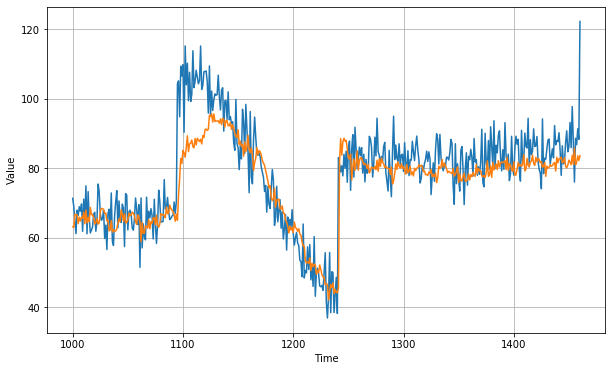

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.021724

<Figure size 432x288 with 0 Axes>

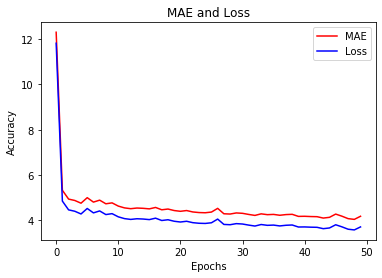

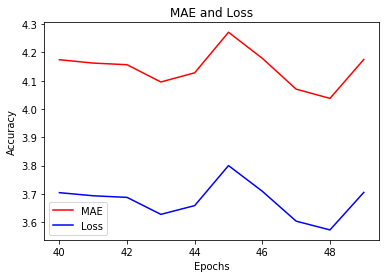

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[40:]
mae_zoom = mae[40:]
loss_zoom = loss[40:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()